### In this notebook, I've first tried to apply HOS to all channels, since always maternal is reconstructed here, I've substracted it from the original data hoping that I would end up with fetal components, then I applied HOS again to see if fetal component present. Unfortunately again only the maternal components


In [1]:
import functions
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB
from copy import deepcopy
import scipy.stats as stats


In [2]:
no_ica_chans = 18
fs=1000
span = 10*fs
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 
window_size=int(1400) # used for higher-order-spectral filtering
time_axis=np.linspace(0,int(window_size)-1,num=int(window_size))

In [3]:

data = functions.array_from_TDMSgroup("patients/P050/P050_S01_D2024-06-13_G39.tdms", "R001")
filtered_data = functions.butter_filter(data)
copied_data = deepcopy(data)

### Interestingly, the original data has too much DC power ( <3Hz), when we apply wavy baseline it removes this DC power and that's why ICA works well with wavy baseline removed

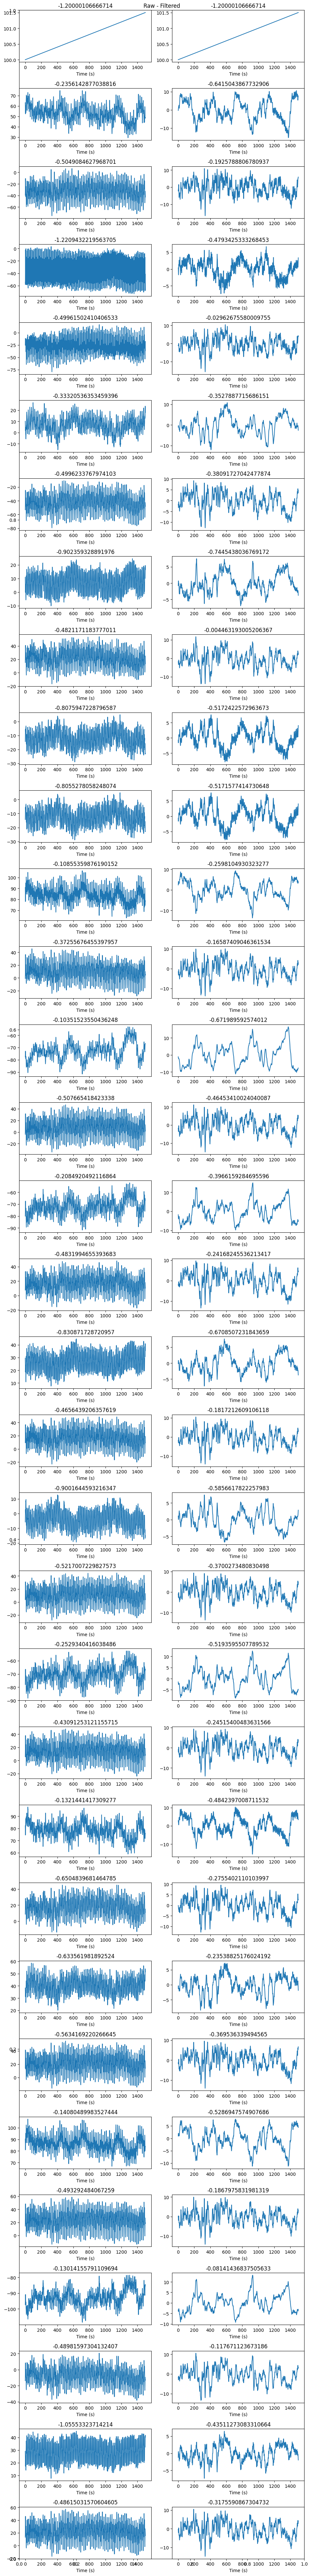

In [19]:
def compare_all_channels(data, filtered_data, start, duration):
    plt.figure(figsize=(10, 80))  # Adjust the width to accommodate 2 columns
    plt.title(f'Raw - Filtered')
    # Loop over each component
    for i in range(data.shape[1]):  # Assuming data.shape[1] gives you 18 components
        # Plot the original data
        plt.subplot(data.shape[1], 2, 2*i + 1)  # 18 rows, 2 columns, odd indices for original data
        plt.plot(data[start:(start + duration)][:, i])
        plt.xlabel('Time (s)')  # Assuming time units are seconds, adjust if different
        plt.title(f"{stats.kurtosis(data[start:(start + duration)][:, i])}")
        plt.tight_layout()
        # Plot the filtered data
        plt.subplot(data.shape[1], 2, 2*i + 2)  # 18 rows, 2 columns, even indices for filtered data
        plt.plot(filtered_data[start:(start + duration)][:, i])
        plt.title(f"{stats.kurtosis(filtered_data[start:(start + duration)][:, i])}")
        plt.xlabel('Time (s)')
        plt.tight_layout()
    plt.show() 
compare_all_channels(data,filtered_data, 100*fs, 1500)



In [17]:
print(len(stats.kurtosis(data)))

33


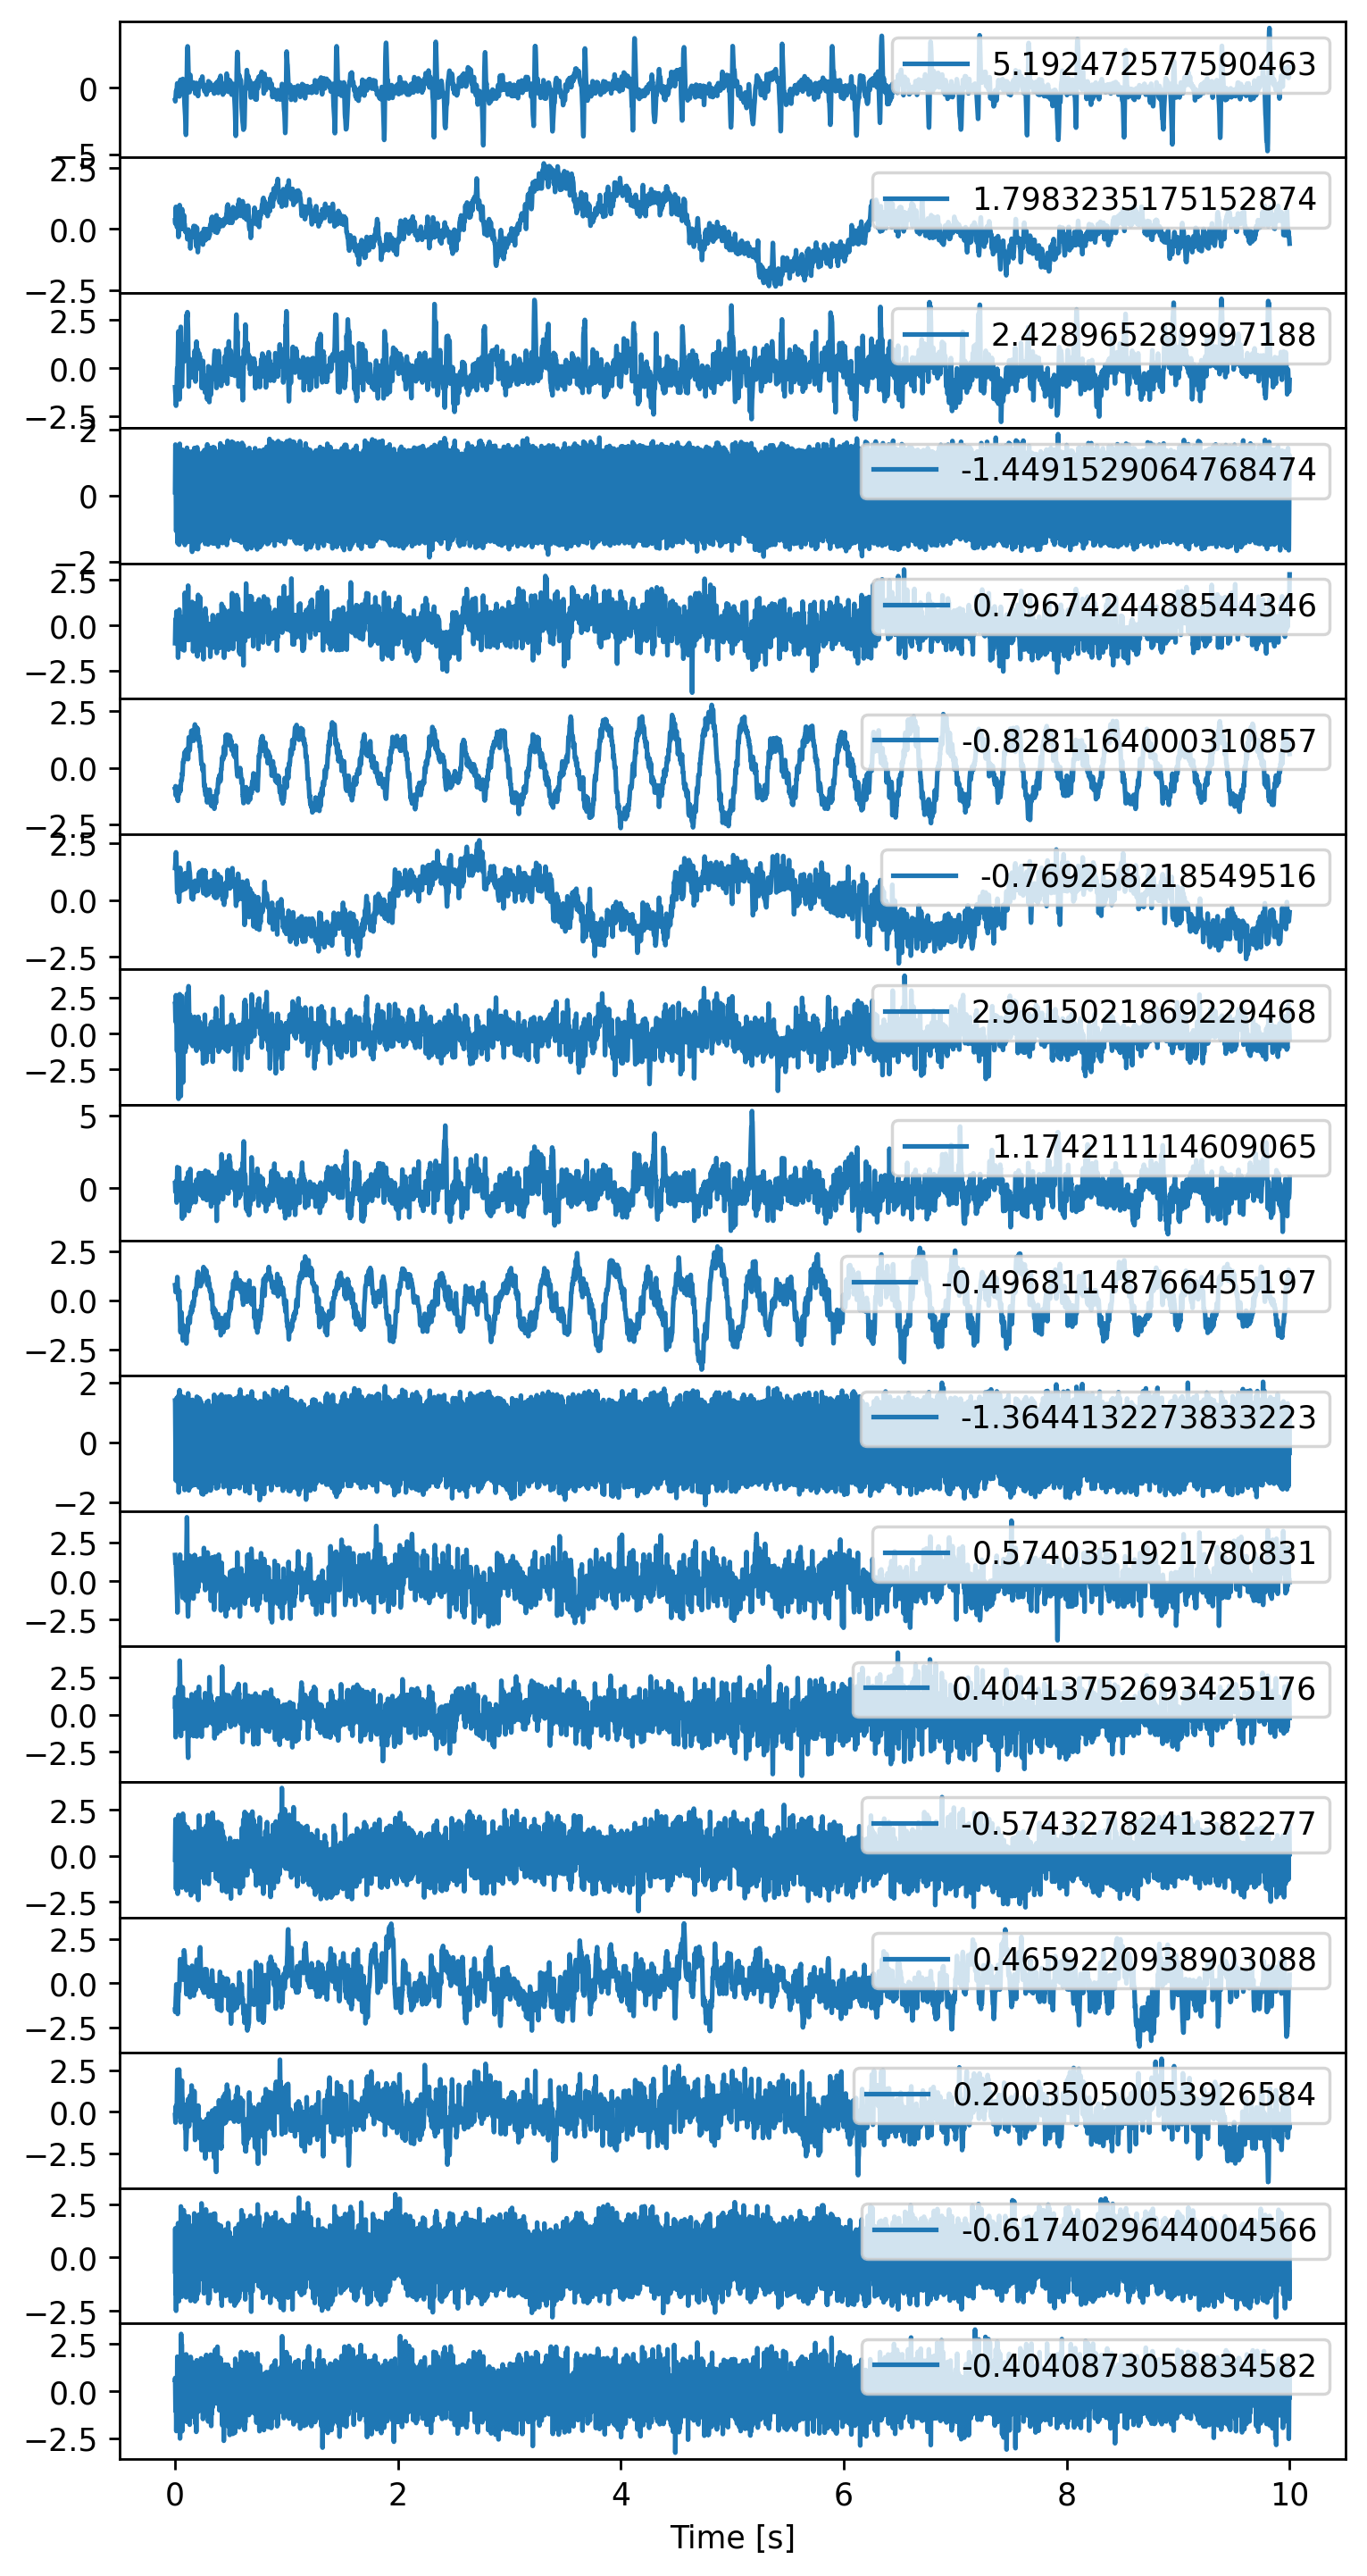

In [5]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=30,algorithm='deflation',max_iter=4000,fun='logcosh',tol=1e-5)
filtered_data_np = np.array(filtered_data[5000:, 1:])

ica_applied = ica.fit_transform(filtered_data_np)
fig, ax = plt.subplots(18, 1, sharex=True, figsize=(18 / 2.54, 36 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(18):
    ax[j].plot(ica_applied[offset:offset+span, j], label=str(stats.kurtosis(ica_applied[:,j])))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

In [ ]:
maternals = np.zeros_like(copied_data)
for channels in range(copied_data.shape[1]):
    beat, detect = apply_hosd(copied_data[:,channels], window_size) 
    maternals[:,channels] = detect

fetals = copied_data - maternals

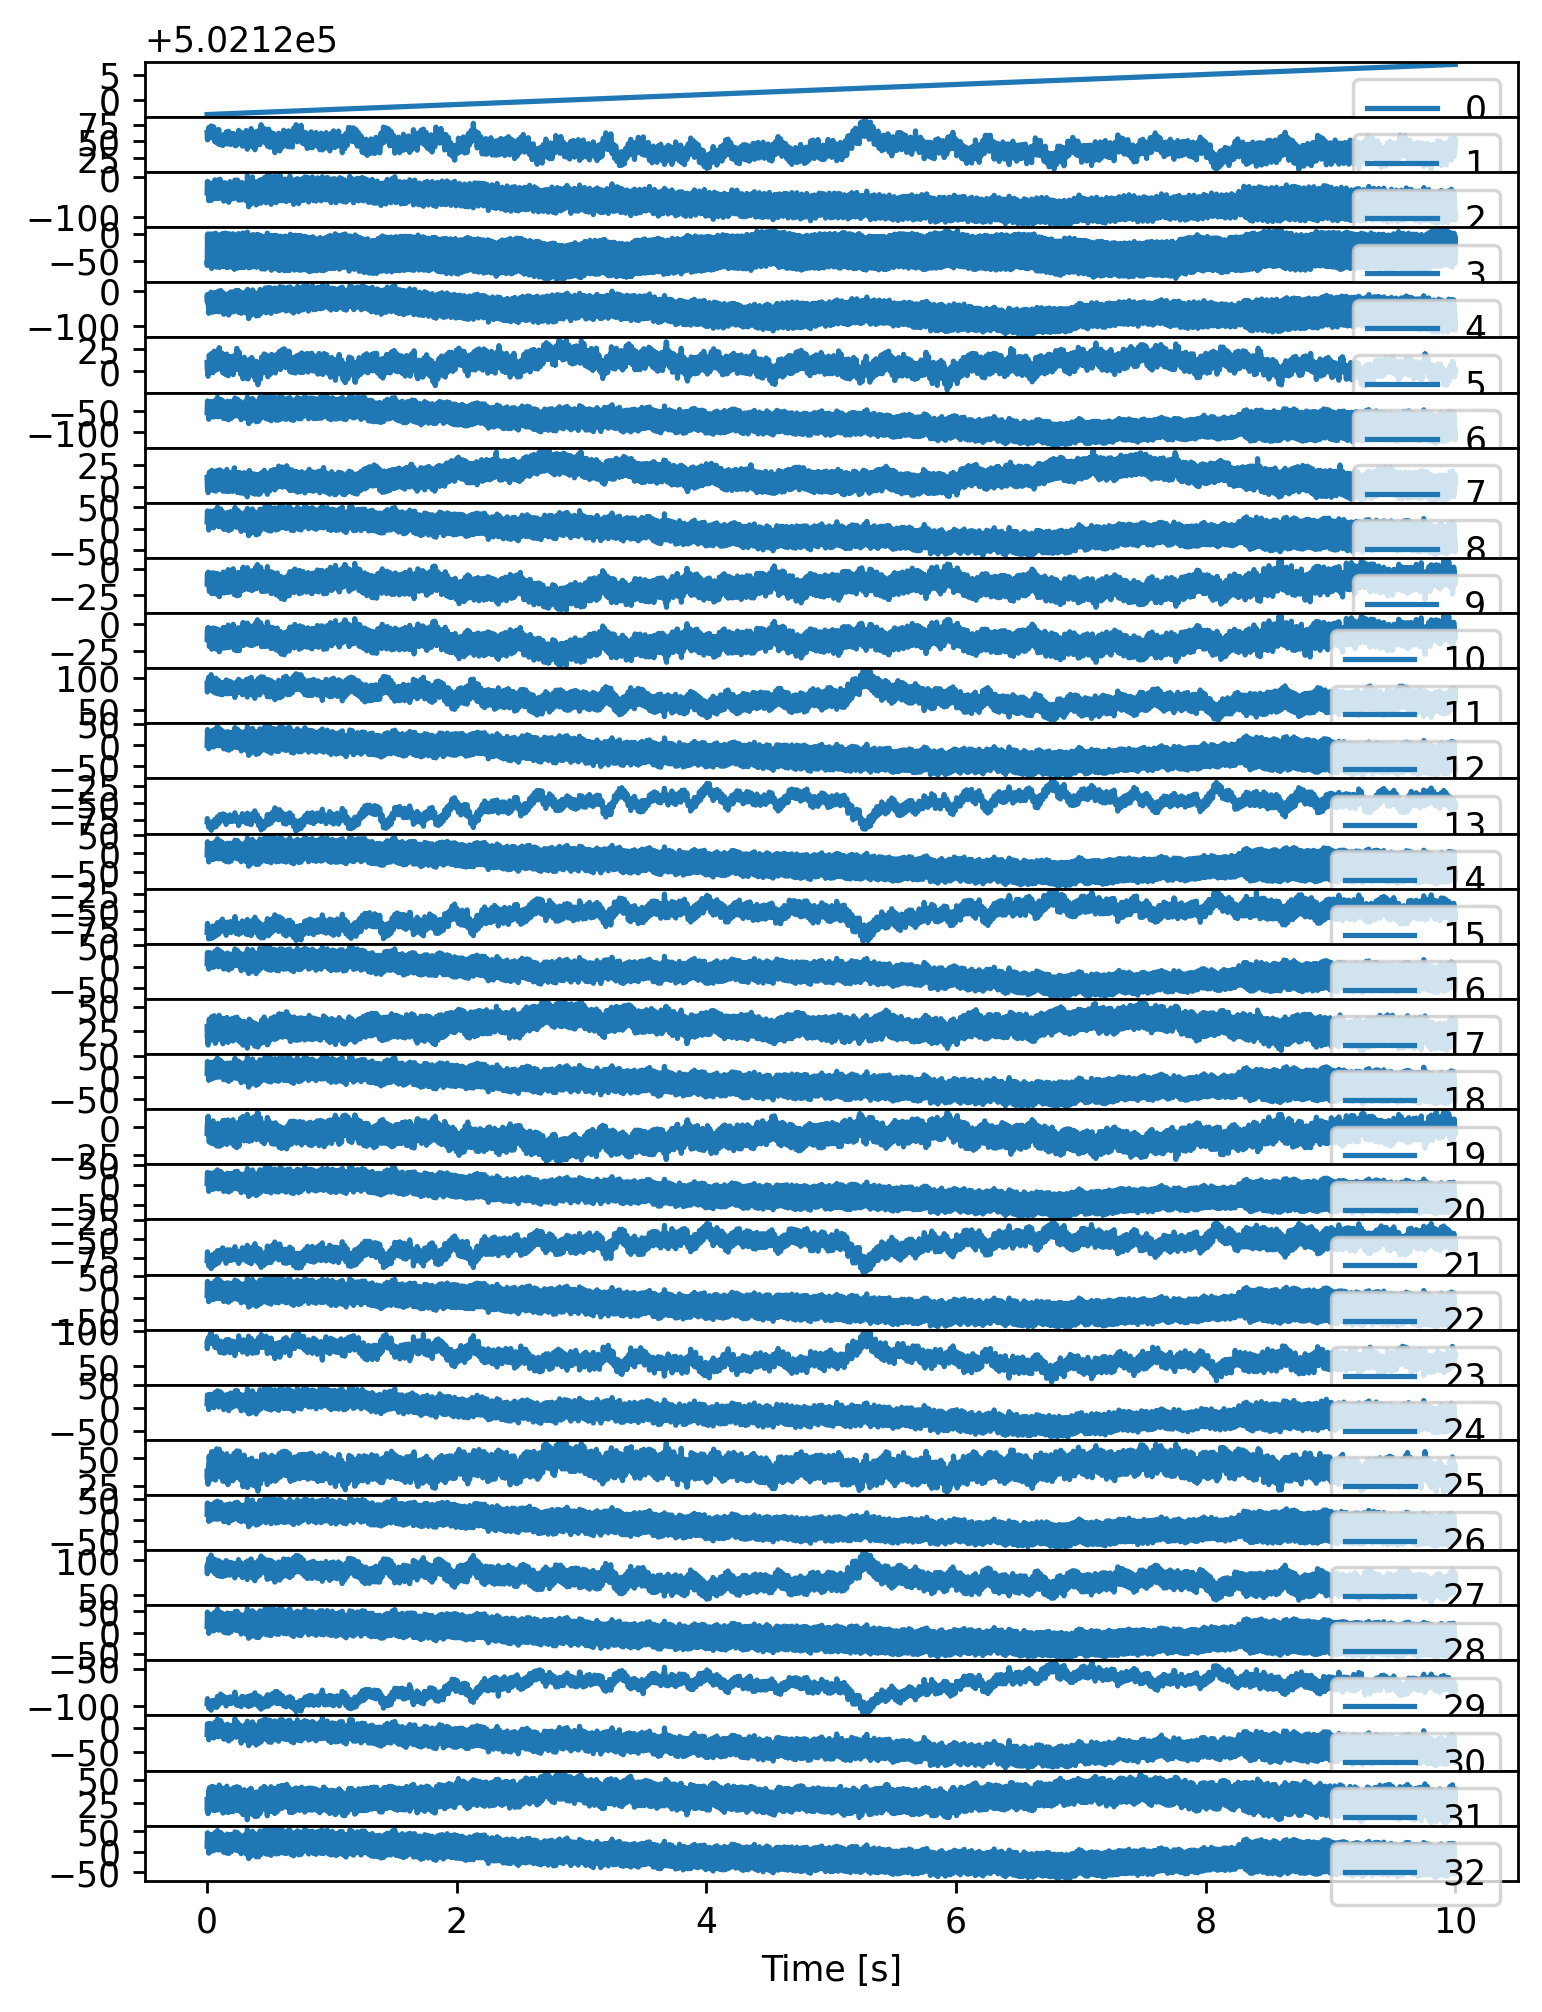

In [9]:
fig, ax = plt.subplots(fetals.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(fetals.shape[1]):
    ax[j].plot(fetals[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

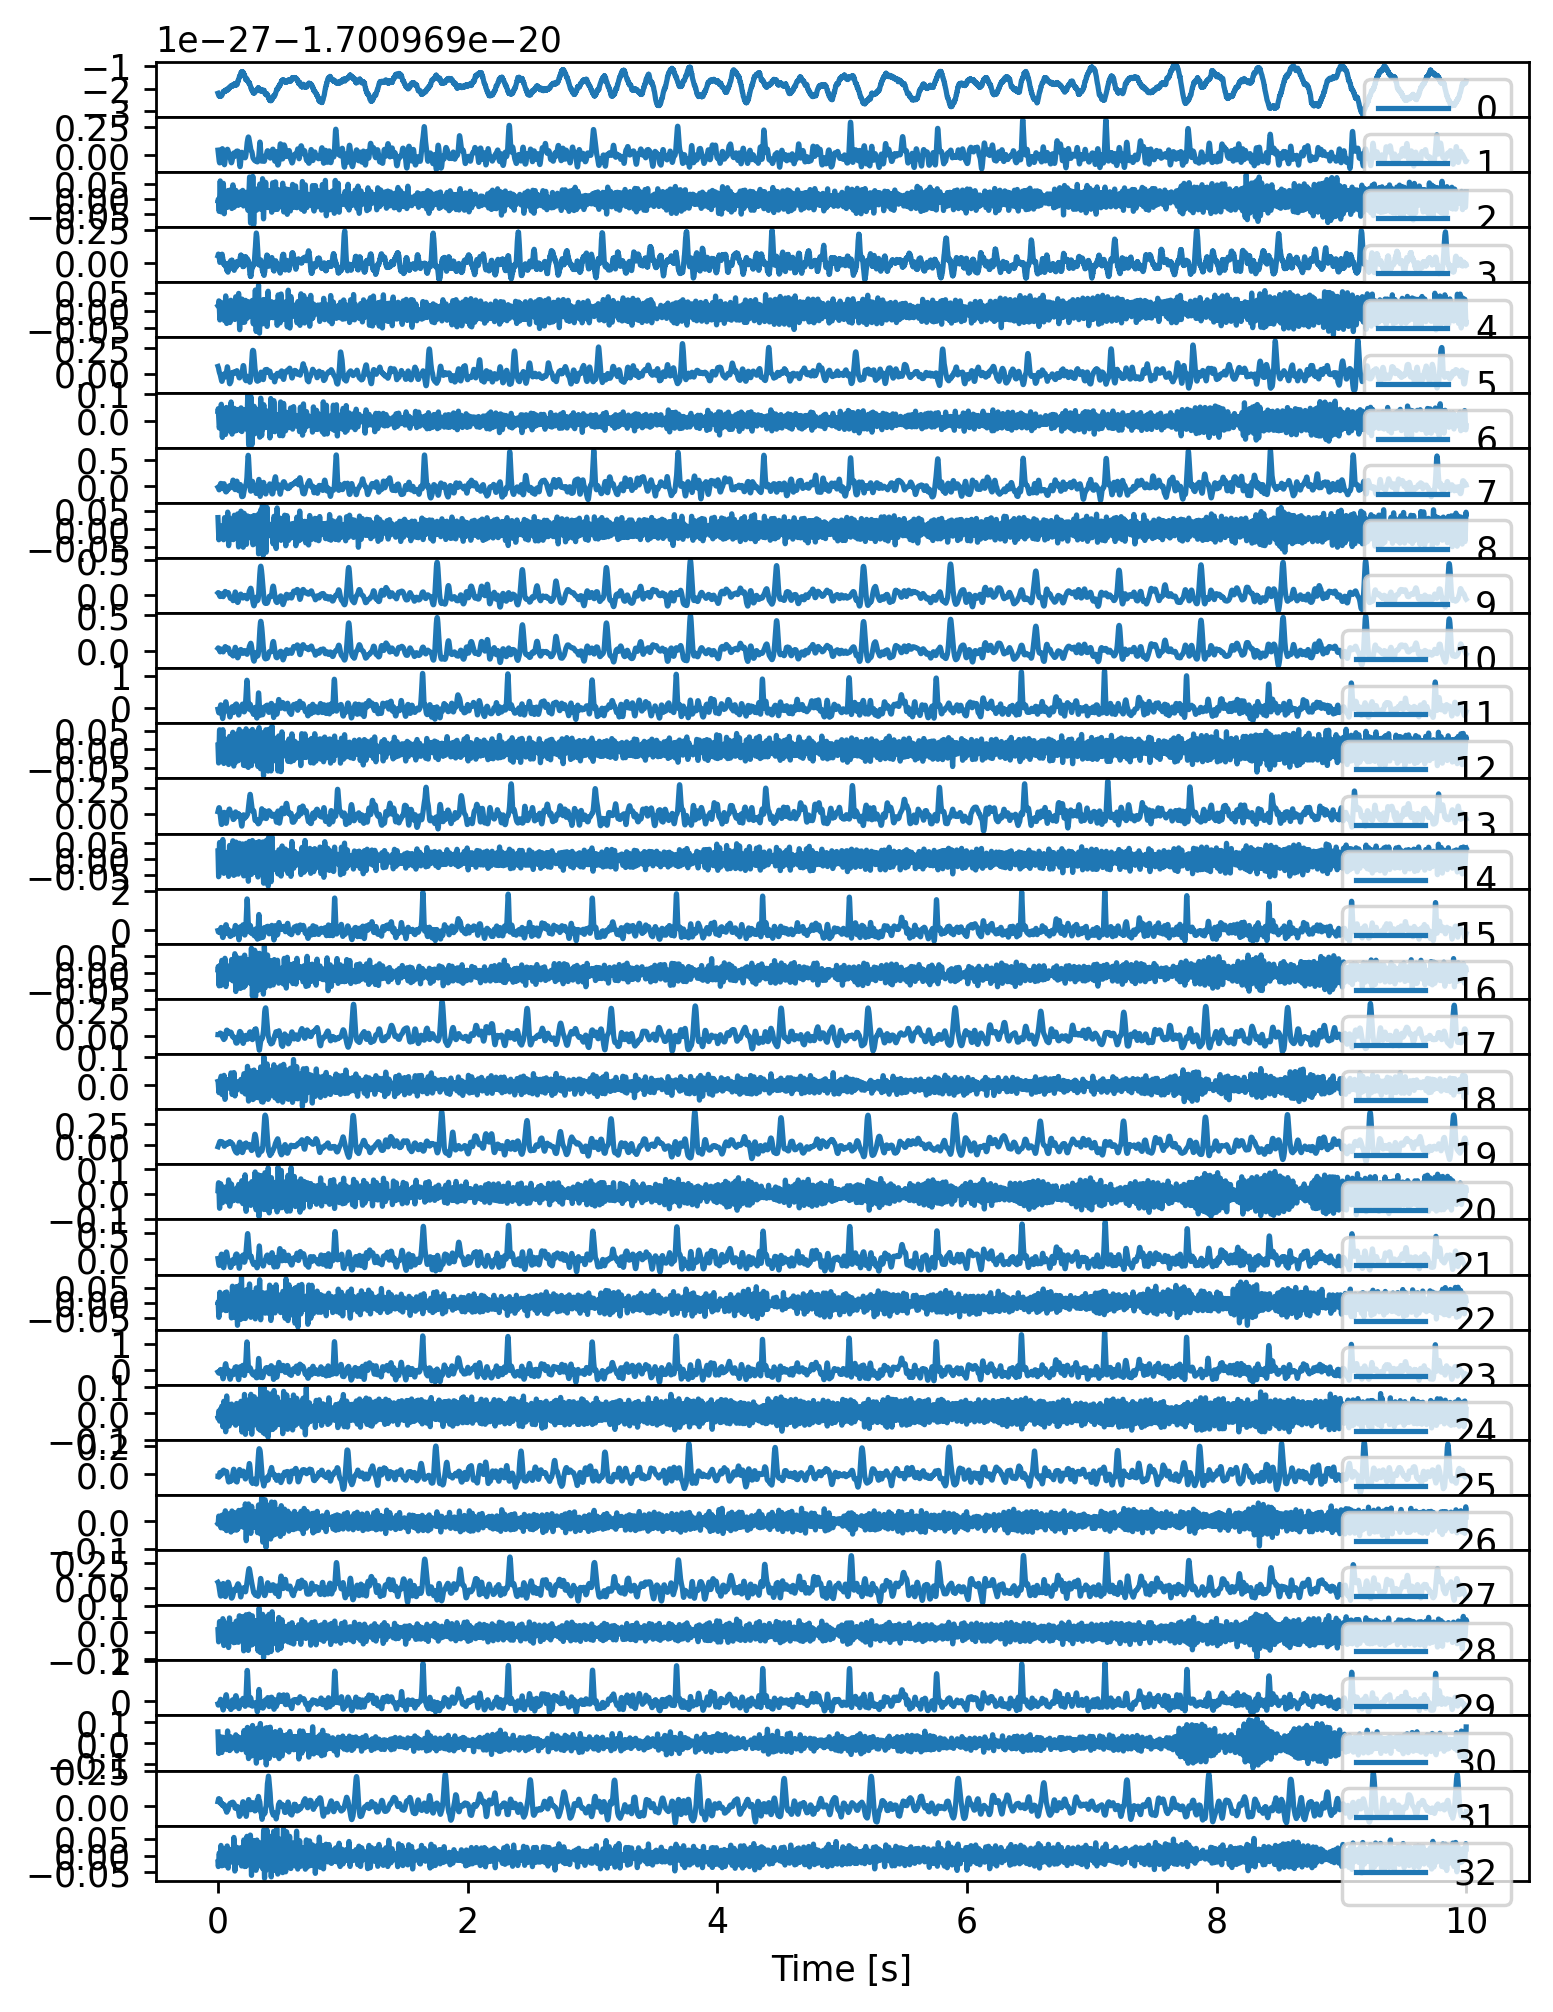

In [10]:
for channels in range(fetals.shape[1]):
    beat, detect = apply_hosd(fetals[:,channels], window_size) 
    fetals[:,channels] = detect

fig, ax = plt.subplots(fetals.shape[1], 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(fetals.shape[1]):
    ax[j].plot(fetals[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()   